In [1]:
'''This salary prediction model pulls job data and predicts salaries across multiple models. 
    It then saves the model and produces a prediction file.'''

'This salary prediction model pulls job data and predicts salaries across multiple models. \n    It then saves the model and produces a prediction file.'

In [2]:
__author__ = "Khalid Rahman"
__email__ = "kirahman2@gmail.com"

### Import packages

In [3]:
#!/usr/bin/env python3
#import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.externals import joblib
import pickle
import os

/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Defining Data class

In [5]:
class Data:
    def __init__(self, train_file, train_target_file, test_file, col_cat, col_num, col_id, col_target):
        '''create train and test dataframes'''
        self.col_cat = col_cat
        self.col_num = col_num
        self.col_all = col_cat + col_num
        self.col_id = col_id
        self.col_target = col_target
        self.train_eda = pd.DataFrame()
        self.train_raw = pd.DataFrame()
        self.test_raw = pd.DataFrame()
        self.train_df = self._create_train_df(train_file, train_target_file)
        self.test_df = self._create_test_df(test_file)
        
    def _create_train_df(self, train_df, train_target):
        '''create train dataframe'''
        target = self._load_file(train_target)
        df = self._load_file(train_df)
        df = self._join_df(df, target, self.col_id)
        df = self._correct_data(df)
        self.train_eda = df
        df = self._clean_data(df)
        df = self._shuffle_data(df)
        self.train_raw = df
        df = self._label_encode(df, self.col_cat)
        return df
    
    def _create_test_df(self, test_file):
        '''create test dataframe'''
        df = self._load_file(test_file)
        df = self._correct_data(df)
        self.test_raw = df
        df = self._label_encode(df, self.col_cat)
        return df

    def _shuffle_data(self, df):
        '''shuffling data'''
        return shuffle(df, random_state=42).reset_index(drop=True)

    def _clean_data(self, df):
        '''remove outliers from data'''
        return df[(df.salary>8) & (df.salary<220)]
    
    def _correct_data(self,df):
        '''correcting data values'''
        list_index = df[ (df['degree']!='HIGH_SCHOOL')
                       & (df['degree']!='NONE') 
                       & (df['major']=='NONE')
                       ].index
        df.loc[list_index,'major'] = 'MISSING'
        return df
    
    def _label_encode(self, df, col_cat):
        '''label encode dataframes'''
        le = LabelEncoder()
        for col in col_cat:
            df[col] = le.fit_transform(df[col])
        return df
         
    def _join_df(self, train_df, train_target, col_id):
        '''join train and target dataframes'''
        return pd.merge(train_df, train_target, on=col_id, how='inner')

    def _load_file(self, file):
        '''load files'''
        return pd.read_csv(file)

### Defining Feature Engineering class

In [6]:
class FeatureEngineering:
    def __init__(self, train_raw, train_df, test_raw, test_df, col_cat, target, col_id):
        '''create train and test dataframes'''
        df_temp = pd.DataFrame()
        self.train_df = train_df
        self.train_raw = train_raw
        self.test_df = test_df
        self.test_raw = test_raw
        self._groupby(self.train_raw, train_df, self.test_raw, col_cat, target)
    
    def _groupby(self, train_raw, train_df, test_raw, col_cat, col_target):
        '''parse through each categorical column and compute mean of each unique value'''
        for i in range(0, len(col_cat)):
            df_temp = self._compute_mean(train_raw, col_cat, i, col_target)
            list_col_temp = df_temp[col_cat[i]]
            list_col_target = df_temp[col_target]
            dict_temp = self._create_dictionary(df_temp, list_col_temp, list_col_target)
            data.train_df[col_cat[i] +'_mean'] = self._map_dictionary(train_raw, col_cat, i, dict_temp)
            data.test_df[col_cat[i] +'_mean'] = self._map_dictionary(test_raw, col_cat, i, dict_temp)
            self._append_columns(train_df, col_cat, i)
        data.col_all = data.col_cat + data.col_num
    
    def _compute_mean(self, train_raw, col_cat, i, col_target):
        '''compute mean of unique categorical values'''
        return train_raw.groupby(col_cat[i])[col_target].mean().sort_values(ascending=True).reset_index()
        
    def _create_dictionary(self, df_temp, list_col_temp, list_col_target):
        '''create dictionary of unique categorical values and mean salary values'''
        dict_temp = {}
        for j in range(0,len(df_temp)):
            dict_temp.update([(list_col_temp[j], list_col_target[j])]) 
        return dict_temp
    
    def _map_dictionary(self, df_eda, col_cat, i, dict_temp):
        '''mapping dictionary values'''
        return df_eda[col_cat[i]].map(dict_temp)
    
    def _append_columns(self, train_df, col_cat, i):
        '''appending new column names to col_num list'''
        data.col_num.append(train_df[col_cat[i] +'_mean'].name)

### Defining Model class

In [7]:
class Model:
    def __init__(self, train_features, train_target, model_container, set_cv, num_proc, dir_pred):
        '''create train dataframe'''
        self.train_df = train_features
        self.target = train_target
        self.filename = 'best_model.sav'
    
    def add_model(self, model):
        '''add new model'''
        model_container[model] = self._score_model(model, self.train_df, 
                                                   self.target, set_cv, num_proc)
        pass_temp = model_container[model]
        self._model_summary(model, pass_temp)
    
    def _model_summary(self, model, pass_temp):
        print(model)
        print('score:', model_container[model],'\n')        
        
    def fit_model(self, model, train_df, target):
        '''fit model'''
        return model.fit(train_df, target)
        
    def predict_model(self, model_selected, test_df, train_df, target, save_best_model):
        '''predict and store best model'''
        model = self.fit_model(model_selected, train_df, target)
        self._save_model(model, self.filename, save_best_model)
        prediction_results = model.predict(test_df)
        self._save_prediction(prediction_results)
        return prediction_results

    def _important_features(self, model):
        '''create feature importance dataframe'''
        if hasattr(model,'feature_importances_'):
            col_feat_rank = pd.DataFrame(model.feature_importances_, columns=['score'])
            col_feat = pd.DataFrame(data.col_all, columns=['feature'])
            df_feat = pd.concat([col_feat,col_feat_rank],axis=1).sort_values('score',ascending=False).reset_index(drop=True)
            print('\n', model)
            print("\nFeature Importances\n", df_feat)
            self._feature_barplot(df_feat)
        else:
            return print("\nModel does not have feature_importances_ attribute.")

    def _feature_barplot(self, df):
        '''create feature importance barplot'''
        sns.barplot(df.score,df.feature, palette='Blues_d', fontsize=14).set_title('Feature Importances', fontsize=16)
        
    def best_scoring_model(self, model_container):
        '''select best scoring model'''
        best_model = min(model_container, key=model_container.get)
        best_score = model_container.get(best_model)
        self._best_model_summary(best_model, best_score)
        return best_model
    
    def _best_model_summary(self, best_model, best_score):
        '''print summary results of best model'''
        print('The best model is:\n', best_model)
        print('\nThe best score is:\n', best_score)
        
    def load_model(self, load_best_model, test_df):
        '''load best model and call feature importance'''
        if load_best_model:
            # figure out how to 
            print('\nLoading saved best model...')
            loading_best_model = joblib.load(self.filename)
            self._important_features(loading_best_model)
            model_pred = loading_best_model.predict(test_df)
        else:
            print('\nNo prediction file was created because load_best_model is set to false.')

    def _save_model(self, model, filename, save_best_model):
        '''save best model'''
        if save_best_model:
            pickle.dump(model, open(filename, 'wb'))
            print('The model has been saved.')
        else:
            print('\nThe best performing model was not saved because save_best_model is set to false.')
        
    def _score_model(self, model, train_df, target_train, set_cv, num_proc):
        '''score model'''
        return -1.0*np.mean(cross_val_score(model, train_df, target_train, scoring='neg_mean_squared_error', cv=set_cv, n_jobs=num_proc))

    def _save_prediction(self, prediction_results):
        '''save predictions as csv file'''
        prediction_results = pd.DataFrame(prediction_results).to_csv(dir_pred)

### Defining parameters to run model

In [8]:
train_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_features.csv'
test_file = '/Users/krahman/work/salarypredictionportfolio_old/data/test_features.csv'
train_target_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_salaries.csv'
col_cat = ['companyId', 'jobType', 'degree', 'major', 'industry']
col_num = ['milesFromMetropolis', 'yearsExperience']
col_all = col_cat + col_num
col_id = 'jobId'
col_target = 'salary'

set_cv = 2
num_proc = -1
save_best_model = False
load_best_model = True
dir_pred = '/Users/krahman/work/salarypredictionportfolio/predictions/test_salaries.csv'
model_container = {}

### Create data object

In [206]:
data = Data(train_file, train_target_file, test_file, col_cat, col_num, col_id, col_target)

### Create feature engineering object

In [207]:
fe = FeatureEngineering(data.train_raw, data.train_df, data.test_raw, 
                        data.test_df, data.col_cat, data.col_target, col_id)

### Finalize training, target and test dataframes for our model

In [208]:
train_features = data.train_df[data.col_all]
train_target = data.train_df[col_target]
test_features = data.test_df[data.col_all]

###
# train_features = data.train_df.loc[:1000,:]
# train_target = data.train_df.loc[:1000,:]
# test_features = data.test_df.loc[:1000,:]
# train_features = train_features[data.col_all]
# train_target = train_target[col_target]
# test_features = test_features[data.col_all]
###

### Create model object

In [209]:
model = Model(train_features, train_target, model_container, set_cv, num_proc, dir_pred)

In [210]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# data.train_df

### Tune model parameters

In [211]:
# import warnings
# warnings.filterwarnings('ignore')

In [212]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data.train_df.drop([col_target,col_id],axis=1), data.train_df[col_target], test_size=0.25)

In [ ]:
###### GBR ######
# best loss=
results = []
list_values = ['ls', 'lad', 'huber', 'quantile']
hyperp = 'loss'
for val in list_values:
    gbr = GradientBoostingRegressor(loss=val, verbose=False)
    gbr.fit(X_train, y_train)
    results.append(
    {'loss': val,
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
    print(val)
    print(pd.DataFrame(results))
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

ls
  loss  train_error  test_error
0   ls   350.378303  351.876126
lad
  loss  train_error  test_error
0   ls   350.378303  351.876126
1  lad   351.835603  353.392903
huber
    loss  train_error  test_error
0     ls   350.378303  351.876126
1    lad   351.835603  353.392903
2  huber   350.071259  351.657185


In [ ]:
# best learning_rate=
results = []
list_values = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10]
list_values = [1e-1,1e-2,1e-3]
hyperp = 'learning_rate'
for val in list_values:
    gbr = GradientBoostingRegressor(learning_rate=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'learning_rate': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# best n_estimators=
results = []
list_values = range(100,600,100)
hyperp = 'n_estimators'                                           ###
for val in list_values:
    gbr = GradientBoostingRegressor(n_estimators=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'n_estimators': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# best subsample=
results = []
list_values = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
hyperp = 'subsample'                                           ###
for val in list_values:
    gbr = GradientBoostingRegressor(subsample=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'subsample': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# best criterion=                                             ###
results = []
list_values = ['friedman_mse', 'mse']
hyperp = 'criterion'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(criterion=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'criterion': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# best min_samples_split=                                             ###
results = []
list_values = range(2,102,10)
hyperp = 'min_samples_split'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(min_samples_split=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'min_samples_split': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# best min_samples_leaf=                                             ###
results = []
list_values = range(2,102,10)
hyperp = 'min_samples_leaf'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(min_samples_leaf=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'min_samples_leaf': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# best min_weight_fraction_leaf=                                             ###
results = []
list_values = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,]
hyperp = 'min_weight_fraction_leaf'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(min_weight_fraction_leaf=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'min_weight_fraction_leaf': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# best max_depth=                                             ###
results = []
list_values = range(1,20,2)
hyperp = 'max_depth'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(max_depth=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'max_depth': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# best min_impurity_decrease=                                             ###
results = []
list_values = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
hyperp = 'min_impurity_decrease'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(min_impurity_decrease=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'min_impurity_decrease': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# best max_features=                                             ###
results = []
list_values = ['auto', 'sqrt', 'log2', None]
hyperp = 'max_features'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(max_features=val, verbose=1) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'max_features': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# best alpha=                                             ###
results = []
list_values = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
hyperp = 'alpha'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(alpha=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'alpha': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [ ]:
# best max_leaf_nodes=                                             ###
results = []
list_values = ['None']
# list_values = range(50,800,50) # TEST THIS, save score of None
hyperp = 'max_leaf_nodes'                                          ###
for val in list_values:
    gbr = GradientBoostingRegressor(max_leaf_nodes=val, verbose=1, random_state=42) ###
    gbr.fit(X_train, y_train)
    results.append(
    {'max_leaf_nodes': val,                                        ###
     'train_error': mean_squared_error(y_train, gbr.predict(X_train)),
     'test_error': mean_squared_error(y_test, gbr.predict(X_test)),
    })
result_final = pd.DataFrame(results).set_index(hyperp).sort_index()
result_final.plot(title=hyperp + ' Learning Curve')
result_final

In [44]:
# Each algorithm needs to have its own class. Within each class, each needs to have its own hyperparameter
# that we decide to tune. Finalize getting max_depth to accept an array. then build another method for n_estimators
# Once we complete that, figure out how to auto select the best parameter, and automatically create the next
# set of parameters to test
class TuningRFR:
    def __init__(self, df, col_target, col_id):
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split(df)
        
    def train_test_split(self, df):
        X_train, X_test, y_train, y_test = train_test_split(df.drop([col_target,col_id],axis=1),
                                                                    df[col_target],
                                                                    test_size=0.25)
        return X_train, X_test, y_train, y_test

    def maxdepth(self, list_maxdepth):
        results = []
        counter = 0
        for val in list_maxdepth:
            model_temp = RandomForestRegressor(max_depth=val, verbose=False,
                                               n_jobs=-1, random_state=42)
            model_temp.fit(self.X_train, self.y_train)
            results = self._create_dictionary(results, val, model_temp, 'max_depth', counter)
            counter = counter + 1
        results_df = self._create_dataframe(results, 'max_depth')
        self._plot_results(results_df, 'max_depth')
        return results_df
    
    def _create_dictionary(self, results, val, model_temp, hyperparameter, counter):
        results.append(
        {'temp': val,
         'train_error': mean_squared_error(self.y_train, model_temp.predict(self.X_train)),
         'test_error': mean_squared_error(self.y_test, model_temp.predict(self.X_test)),
        })
        temp = results[counter]
        temp[hyperparameter] = temp.pop('temp')
        return results
# test this, remove _fixing word ext., comment out old nestimators, try again. then begin using standard
# ways to tune models... Just have a separate notebook or something.. 
    def nestimators_fixing(self, list_nestimators):
        results = []
        counter = 0
        for val in list_nestimators:
            model_temp = RandomForestRegressor(n_estimators=val, verbose=False,
                                               n_jobs=-1, random_state=42)
            model_temp.fit(self.X_train, self.y_train)
            results = self._create_dictionary(results, val, model_temp, 'n_estimators', counter)
            counter = counter + 1
        results_df = self._create_dataframe(results, 'n_estimators')
        self._plot_results(results_df, 'n_estimators')
        return results_df

    def nestimators(self, list_nestimators):
        results = []
        for val in list_nestimators:
            print(val)
            model_temp = RandomForestRegressor(n_estimators=val, verbose=False,
                                               n_jobs=-1, random_state=42)
            model_temp.fit(self.X_train, self.y_train)
            results.append(
            {'n_estimators': val,
             'train_error': mean_squared_error(self.y_train, model_temp.predict(self.X_train)),
             'test_error': mean_squared_error(self.y_test, model_temp.predict(self.X_test)),
            })
        results_df = self._create_dataframe(results, 'n_estimators')
        self._plot_results(results_df, 'n_estimators')
        return results_df
    
    def maxfeatures(self, list_maxfeatures):
        results = []
        counter = 0
        for val in list_maxfeatures:
            model_temp = RandomForestRegressor(max_features=val, verbose=False,
                                               n_jobs=-1, random_state=42)
            model_temp.fit(self.X_train, self.y_train)
#             results = self._create_dictionary(results, val, model_temp, 'max_features')
            
            results.append(
            {'max_features': val,
             'train_error': mean_squared_error(self.y_train, model_temp.predict(self.X_train)),
             'test_error': mean_squared_error(self.y_test, model_temp.predict(self.X_test)),
            })
        results_df = self._create_dataframe(results, 'max_features')
        self._plot_results(results_df, 'max_features')
        return results_df
    
    def minsamplesleaf(self, list_minsamplesleaf):
        results = []
        for val in list_minsamplesleaf:
            model_temp = RandomForestRegressor(min_samples_leaf=val, verbose=False,
                                               n_jobs=-1, random_state=42)
            model_temp.fit(self.X_train, self.y_train)
#             results = self._create_dictionary(results, val, model_temp, 'min_samples_leaf')
            results.append(
            {'min_samples_leaf': val,
             'train_error': mean_squared_error(self.y_train, model_temp.predict(self.X_train)),
             'test_error': mean_squared_error(self.y_test, model_temp.predict(self.X_test)),
            })
        results_df = self._create_dataframe(results, 'min_samples_leaf')
        self._plot_results(results_df, 'min_samples_leaf')
        return results_df
    
    def _create_dataframe(self, results, hyperparameter):
        return pd.DataFrame(results).set_index(hyperparameter).sort_index()
        
    def _plot_results(self, results_df, hyperparameter):
        results_df.plot(title=hyperparameter + ' score')
        
tuning_rfr = TuningRFR(data.train_df, col_target, col_id)
# tuning_rfg.nestimators(range(1,3))
# tuning_rfg.maxfeatures(["auto", None, "sqrt"])
# tuning_rfr.nestimators(range(2,4))

In [67]:
y_train = data.train_df.salary
X_train = data.train_df.drop(['jobId','salary'],axis=1)

(992418,)
(992418, 12)


In [ ]:
# oob_score, n_estimators, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, 
# max_features, max_leaf_nodes,min_impurity_decrease, bootstrap

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.4s finished


,oob_score
max_depth,
8,0.603584
10,0.624578
12,0.638769
14,0.634440


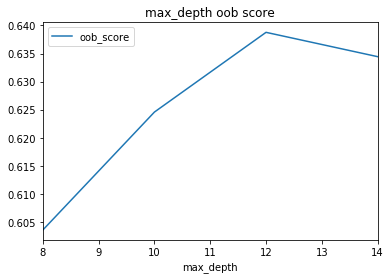

In [172]:
# best max_depth=
list_values = range(8,16,2)
hyperp = 'max_depth'
results = []
for val in list_values:
    rfr = RandomForestRegressor(max_depth=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.8s finished


,oob_score
max_depth,
10,0.627049
11,0.635253
12,0.638442
13,0.639957
14,0.633507
15,0.628921


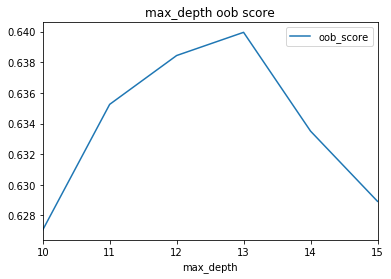

In [174]:
# best max_depth=13
list_values = range(10,16)
hyperp = 'max_depth'
results = []
for val in list_values:
    rfr = RandomForestRegressor(max_depth=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

,oob_score
min_samples_split,
0.000219,0.641072
0.000220,0.640972
0.000221,0.640768
0.000222,0.636921
0.000223,0.641165
0.000224,0.640867
0.000225,0.640829
0.000226,0.639705
0.000227,0.640189


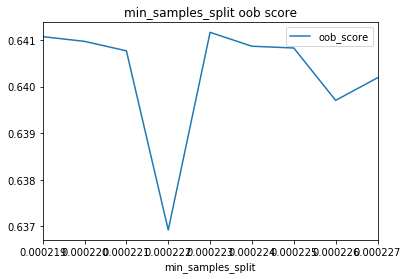

In [129]:
# best min_samples_split (<1) = 0.000223 score=0.641165
list_values = [1e-3,1e-4,1e-4,1e-5]
list_values = [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.002]
list_values = [.00019,.0002,.000211,.00022,.00023,.00024,.00025,.00026,.00027,.00028,.00029,.0003]
list_values = [.000211,.000212,.000213,.000214,.000215,.000216,.000217,.000218,.000219]
list_values = [.000219,.000220,.000221,.000222,.000223,.000224,.000225,.000226,.000227]
hyperp = 'min_samples_split'
results = []
for val in list_values:
    rfr = RandomForestRegressor(min_samples_split=val, verbose=False, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   26.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parall

,oob_score
min_samples_split,
175,0.641146
176,0.641715
177,0.640615
178,0.639274
179,0.639845
180,0.638809
181,0.639591
182,0.638856
183,0.638712


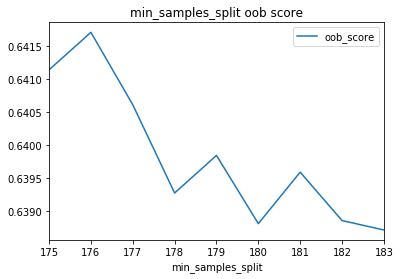

In [128]:
# best min_samples_split (>1) = 176 score=0.641715
# list_values = [50,100,150,200,25,300,350]
list_values = range(175,184)
hyperp = 'min_samples_split'
results = []
for val in list_values:
    rfr = RandomForestRegressor(min_samples_split=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

,oob_score
min_samples_leaf,
74,0.642372
75,0.641522
76,0.642872
77,0.643692
78,0.642358
79,0.640394


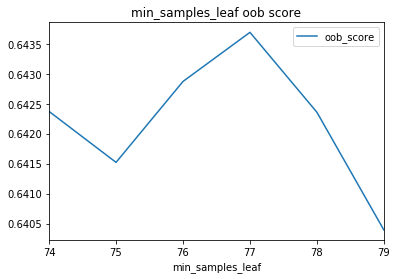

In [131]:
# best min_samples_leaf=77 76,77,78
list_values = range(74,80)
hyperp = 'min_samples_leaf'
results = []
for val in list_values:
    rfr = RandomForestRegressor(min_samples_leaf=val, verbose=False, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

,oob_score
min_weight_fraction_leaf,
0.000050,0.638117
0.000060,0.641142
0.000070,0.641720
0.000080,0.639702
0.000090,0.640280
0.000092,0.642510
0.000093,0.642216
0.000094,0.640562
0.000095,0.640457


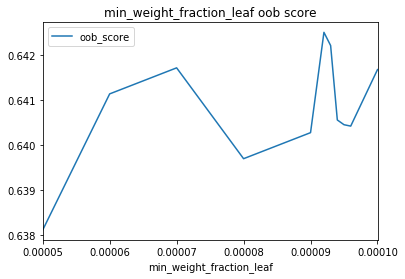

In [135]:
# best min_weight_fraction_leaf=0.000092
list_values = [0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
list_values = [0, .00008,.00007,.00006,.00005,.00004,.00003,.00002,.00001]
list_values = [.00009,.000092,.000093,.000094,.000095,.000096,.0001]
hyperp = 'min_weight_fraction_leaf'
results = []
for val in list_values:
    rfr = RandomForestRegressor(min_weight_fraction_leaf=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parall

,oob_score
max_features,
0.40,0.551685
0.50,0.550201
0.51,0.551900
0.52,0.550538
0.53,0.551605
0.54,0.552517
0.55,0.548812
0.56,0.550548
0.57,0.552449


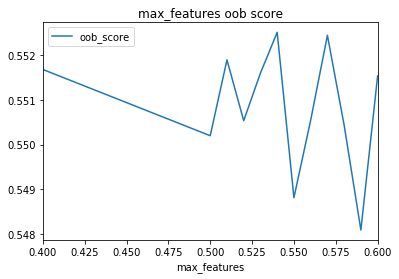

In [146]:
# best max_features='sqrt' score: 0.550349, or 0.54 score:0.552517
# list_values = [.4,.5,.51,.52,.53,.54,.55,.56,.57,.58,.59,.6]
# list_values = ['auto', 'sqrt', 'log2', None]
# list_values = ['sqrt']
hyperp = 'max_features'
results = []
for val in list_values:
    rfr = RandomForestRegressor(max_features=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   24.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.7s finished


,oob_score
max_leaf_nodes,
5117,0.637586
5118,0.639838
5119,0.638655
5120,0.638173
5121,0.637005


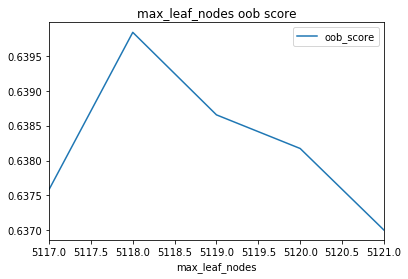

In [168]:
# best max_leaf_nodes= 5118
list_values = [5,25,50,75,100,125,150,175,200,None]
list_values = range(1000,20000,100)
list_values = range(5117,5122)
hyperp = 'max_leaf_nodes'
results = []
for val in list_values:
    rfr = RandomForestRegressor(max_leaf_nodes=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parall

,oob_score
min_impurity_decrease,
0.0089,0.637334
0.0090,0.636676
0.0091,0.639488
0.0092,0.637855
0.0093,0.638629
0.0094,0.639240
0.0095,0.637630
0.0096,0.637786
0.0097,0.636051


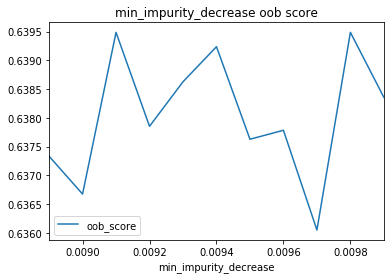

In [183]:
# min_impurity_decrease = 0.0098
list_values = [0,1e-1,1e-2]
# list_values = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]
list_values = [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]
list_values = [0,.001,.002,.003,.004,.005,.006,.007,.008,.009]
list_values = [.0089,.0090,.0091,.0092,.0093,.0094,.0095,.0096,.0097,.0098,.0099]

hyperp = 'min_impurity_decrease'
results = []
for val in list_values:
    rfr = RandomForestRegressor(min_impurity_decrease=val, verbose=True, n_jobs=-1, oob_score=True)
    rfr.fit(X_train, y_train) 
    results.append(
                   {hyperp: val,
                    'oob_score': rfr.oob_score_,
                  })
results = pd.DataFrame(results).set_index(hyperp).sort_index()
results.plot(title=hyperp + ' oob score')
print(results.max())
results

In [205]:
# Grid Search
from sklearn.model_selection import GridSearchCV
rfr = RandomForestRegressor()

grid_values = {'n_estimators':[13,73,74], 'max_depth':[12,13,14], 'min_samples_split':[175,176,177], 
               'min_samples_leaf':[76,77,78], 'min_weight_fraction_leaf':[0.000092, 0.000093, 0.000094], 
               'max_features':['sqrt','auto'],'max_leaf_nodes':[5117,5118,5119], 
               'min_impurity_decrease':[0.0097,0.0098,0.0099]}

grid_rfr_acc = GridSearchCV(rfr, param_grid = grid_values, cv=3, verbose=6, n_jobs=-1, scoring = 'neg_mean_squared_error')
grid_rfr_acc.fit(X_train, y_train)

Fitting 3 folds for each of 4374 candidates, totalling 13122 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.0min


KeyboardInterrupt: 

In [202]:
grid_rfr_acc.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [18]:
X_train, X_test, y_train, y_test = tuning_rfr.train_test_split(data.train_df)

### Add model, score, select best model, create prediction file and print summary

In [24]:
# model.add_model(GradientBoostingRegressor(loss='ls', n_estimators=500, max_depth=5))
# model.add_model(ElasticNet())
# model.add_model(LinearRegression())
model.add_model(RandomForestRegressor(max_depth=7))

selected_model = model.best_scoring_model(model_container)
pred_result = model.predict_model(selected_model, test_features,
                                  train_features, train_target, save_best_model)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
score: 436.81546535805427 

The best model is:
 DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

The best score is:
 389.143036087255

The best performing model was not saved because save_best_model is set to false.


### Load best model and create prediction


Loading saved best model...


/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DummyRegressor from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/krahman/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GradientBoostingRegressor from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)



 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Feature Importances
                 feature     score
0          jobType_mean  0.403004
1       yearsExperience  0.181435
2   milesFromMetropolis  0.125192
3         industry_mean  0.116661
4           degree_mean  0.070938
5            major_mean  0.062944
6               jobType  0.033245
7              industry  0.002198
8                degree  

AttributeError: 'Rectangle' object has no property 'fontsize'

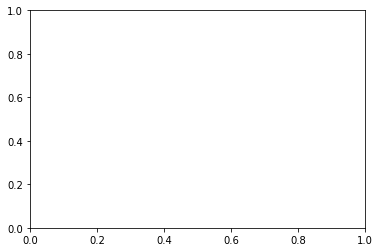

In [25]:
best_model_loaded = model.load_model(load_best_model, test_features)
# best_model_loaded

### EDA

In [ ]:
# delete once finished
train_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_features.csv')
train_target_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_salaries.csv')
test_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/test_features.csv')

In [ ]:
class Heatmap:
    def __init__(self, train_df, target_df, title):
        '''merge training and target df'''
        self.df = self._merge_df(train_df, target_df)
        self.col = self.df.columns
        self.target = col_target
        self.heatmap = self._create_corr_df(self.df, self.col, self.target, title)

    def _merge_df(self, df, target):
        '''merging training and target dataframes''' 
        return pd.merge(left=target, right=df, on=col_id, how='inner')

    def _create_corr_df(self, df, col, target, title):
        '''creates correlation matrix from train_df'''
        corr = df[self.col].corr()
        self._create_heatmap(corr)
        self._set_title(title)
        
    def _create_heatmap(self, corr):
        '''creates heatmap from correlation matrix'''
        plt.figure(figsize=(4,3))
        return sns.heatmap(corr, xticklabels=corr.columns.values, 
                           yticklabels=corr.columns.values, cmap='Blues', annot=True)
        
    def _set_title(self, title):
        '''sets title of correlation matrix'''
        plt.title(title)

In [ ]:
class Boxplot:
    def __init__(self, train_eda, target):
        '''create train and target dataframes'''
        self.df = train_eda
        self.target = target
        
    def create_boxplot(self, val, title):
        '''create boxplot'''
        self._create_subplot()
        self._set_title(title)
        col_avgs = self._calc_averages(self.df, self.target, val)
        sns.boxplot(val, self.target, data=self.df, width=.3, color='#eeefff', order=col_avgs)
        
    def create_dual_boxplot(self, col1, val1, val2, col2, title):
        '''create dual axis boxplot'''
        self._create_subplot()
        self._set_title(title)
        col_avgs = self._calc_averages(self.df, self.target, col2)
        df = self._create_dataframe(self.df, self.target, col1, val1, val2, col2)
        sns.boxplot(x=col2, y=self.target, hue=col1, data=df, palette='Set3', order=col_avgs)
    
    def _create_dataframe(self, df, target, col1, val1, val2, col3):
        '''create dataframe for dual boxplot'''
        return df[(df[col1]==val1) | (df[col1]==val2)].sort_values(self.target, ascending=True)
    
    def _calc_averages(self, df, target, val):
        '''calculate mean values'''
        df = self.df[[val, target]].groupby(val).mean().sort_values(target, ascending=True).reset_index()
        return df[val].values
    
    def _create_subplot(self):
        '''create subplot'''
        plt.subplots(figsize=(12,6.5))
        
    def _set_title(self, title):
        '''create title'''
        plt.title(title)

In [ ]:
sns.pairplot(data.train_eda)

KeyboardInterrupt: 

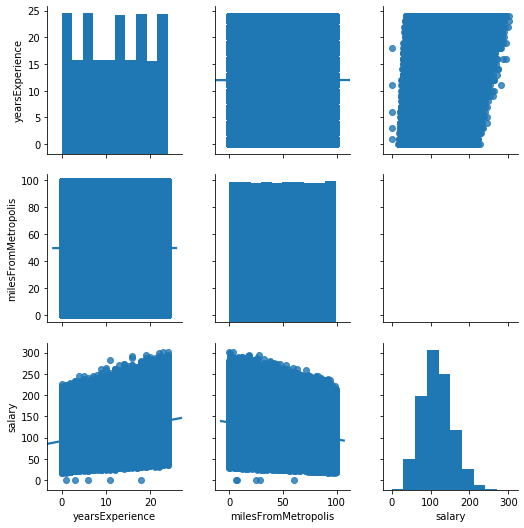

In [26]:
sns.pairplot(data.train_eda, kind='reg')

### Instantiate Boxplot and Heatmap objects

In [ ]:
bp = Boxplot(data.train_eda, col_target)
Heatmap(train_features_df, train_target_df, 'Heatmap of Correlation Matrix');

In [ ]:
bp.create_dual_boxplot('degree', 'HIGH_SCHOOL', 'NONE', 'jobType', 'Salary Versus Position & Degree')

In [ ]:
train_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_features.csv')
train_target_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_salaries.csv')
test_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/test_features.csv')

In [ ]:
train_features_df.head()

In [19]:
train_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [20]:
test_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [21]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [22]:
train_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [23]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [24]:
train_features_sum = train_features_df.duplicated().sum()
train_target_sum = train_target_df.duplicated().sum()
test_features_sum = test_features_df.duplicated().sum()
columns = train_features_df.columns
print('Train features duplicates: {}\nTrain target duplicates: {} \nTest features duplicates: {}\n'.format(train_features_sum, train_target_sum, test_features_sum))
print('Train feature columns:\n', list(columns))

Train features duplicates: 0
Train target duplicates: 0 
Test features duplicates: 0

Train feature columns:
 ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']


In [25]:
col_num = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']
col_cat = ['yearsExperience', 'milesFromMetropolis']
col_id = 'jobId'

In [26]:
train_features_df.describe(include = np.number)

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [27]:
train_features_df.describe(include = np.object)

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684802051,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In [28]:
train_df = pd.merge(train_features_df, train_target_df, on=col_id)
train_target = train_target_df

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [30]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


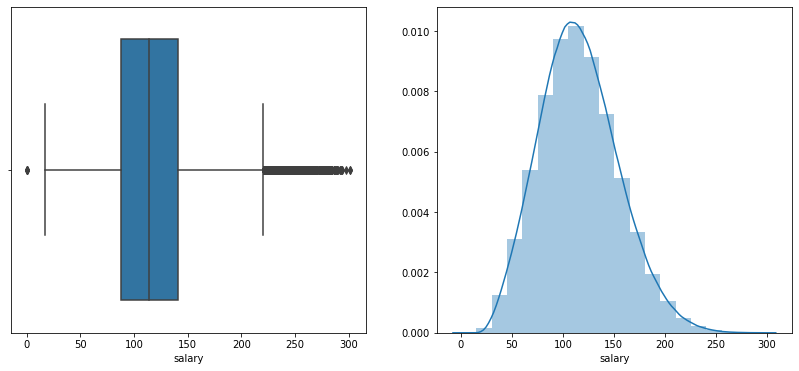

The upper and lower bounds for potential outliers are 220.5 and 8.5.


In [31]:
class TargetVisualization:
    def __init__(self, train_eda, target):
        '''create train and target dataframe'''
        self.df = train_eda
        self.target = target
        self._create_plots()
        self._calculate_iqr()
        
    def _create_plots(self):
        '''create boxplot and distplot'''
        plt.figure(figsize=(14,6))
        plt.subplot(1,2,1)
        sns.boxplot(self.df[self.target])
        plt.subplot(1,2,2)
        sns.distplot(self.df[self.target], bins=20)
        plt.show()
        
    def _calculate_iqr(self):
        '''calculate iqr'''
        stat = self.df[self.target].describe()
        IQR = stat['75%'] - stat['25%']
        upper = stat['75%'] + 1.5 * IQR
        lower = stat['25%'] - 1.5 * IQR
        print('The upper and lower bounds for potential outliers are {} and {}.'.format(upper,lower))

tv = TargetVisualization(data.train_eda, data.col_target)

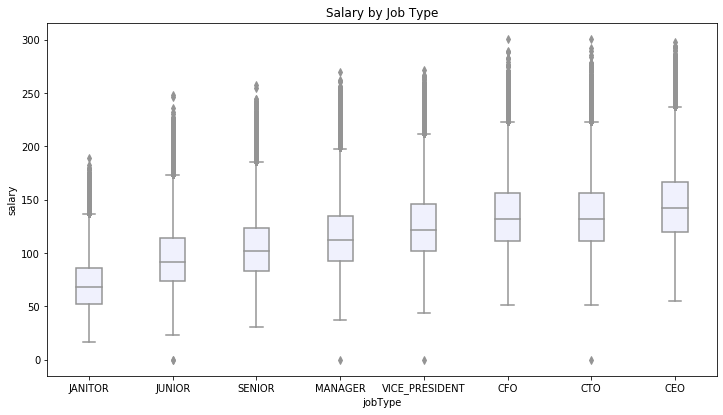

In [33]:
bp.create_boxplot('jobType', 'Salary by Job Type')

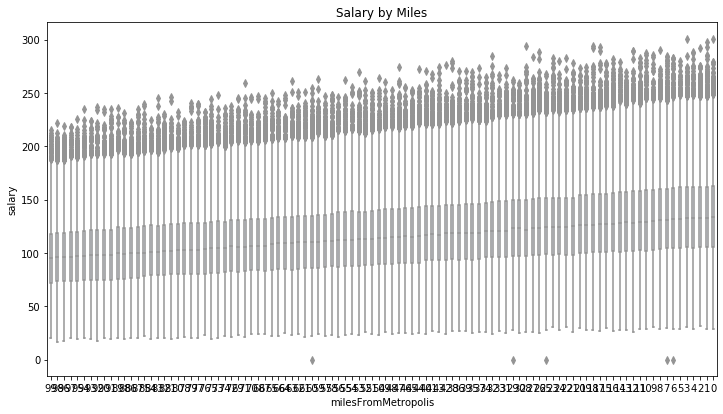

In [34]:
bp.create_boxplot('milesFromMetropolis', 'Salary by Miles')

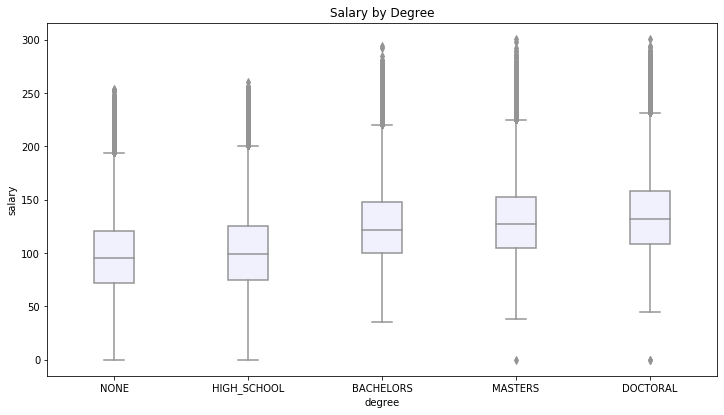

In [35]:
bp.create_boxplot('degree', 'Salary by Degree')

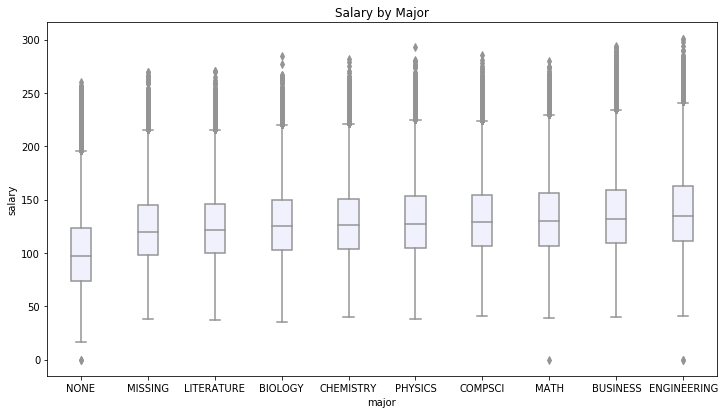

In [36]:
bp.create_boxplot('major', 'Salary by Major')

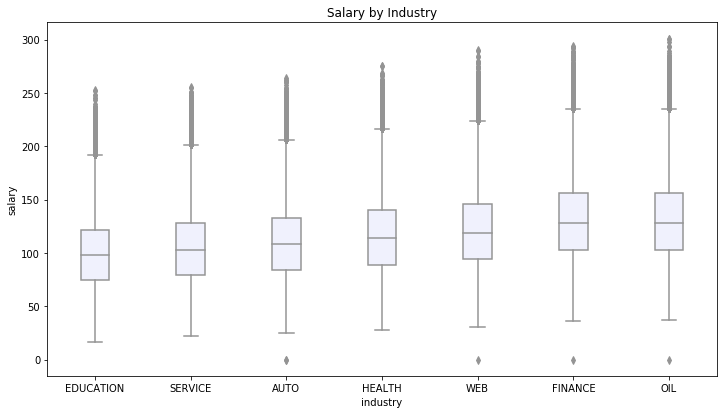

In [37]:
bp.create_boxplot('industry', 'Salary by Industry')

### ---- 11 Automate pipeline ----

In [38]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset